# Magic the Gathering Card Price Prediction
*David Mitchell, Vasiliy Melkozerov, Jason Turner, Stephen FitzSimon*

## Key Takeaways
- Takeaway 1

## Contents <a name='contents'></a>
1. <a href='#intro'>Introduction</a>
2. <a href='#explore'>Explore</a>
    1. <a href='#q_1'>Question 1</a>
3. <a href='#model'>Modeling</a>
    1. <a href='#baseline'>Basline Model</a>
    2. <a href='#train_validate_model'>Modeling on Train and Validate</a>
    3. <a href='#final_model'>Final Model</a>
4. <a href='#conclusions'>Conclusions</a>

In [1]:
# Data Science libraries
import pandas as pd
from scipy import stats

# Custom modules
import acquire
import prepare
import explore

# import model

#ignore minor warnings
import warnings
warnings.filterwarnings("ignore")

## Wrangle

In [2]:
# Acquire and prepare data returned as a dataframe
df_in = acquire.get_data(query_url = False)
print(df_in.shape)
df_in = prepare.prepare_dataframe(df_in)
train, validate, test = prepare.split_data(df_in)
train.shape, validate.shape, test.shape

Getting file from URL...
Retrieved data from url!
Saved data to file!
(70932, 83)


((40311, 60), (6719, 60), (6719, 60))

## Introduction <a name='intro'></a>

<a href='#contents'>Return to Contents</a>

## Explore <a name='explore'></a>

### Key Explore Takeaways
- Takeaway 1

### Discussion

<a href='#contents'>Return to Contents</a>

### Question 1 <a name='q_1'></a>

#### Key Takeaways For Question 1
- The legality of a card does have an effect on price
- The effect is disproportionate among the legalities
- The difference of the price is dependent on what legalities the card is in

### Discussion

The goal was to find tangable differences in Key Takeaways For Question 1
 price based off of its legality.

#### Visualization

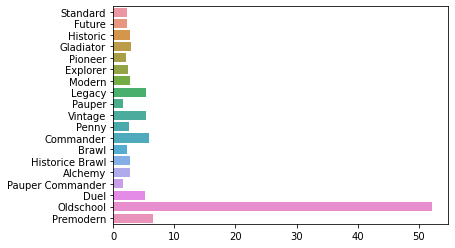

In [3]:
explore.get_legalites_chart(train)

#### Hypothesis Testing
- $H_0$: There is no correlation between legality and usd
- $H_a$: There is a correlation between legality and price

In [4]:
explore.hypothesis_test_legalities(train)

10.412185191299939 1.1746763888223343e-25 0.05
We reject the null hypothesis


<a href='#contents'>Return to Contents</a>

## Modeling <a name = 'model'></a>

### Key Modelling Takeaways
- Takeaway 1

### Discussion

<a href='#contents'>Return to Contents</a>

### Baseline Model <a name='baseline'></a>

In [5]:
# basline model code

<a href='#contents'>Return to Contents</a>

### Modeling on Train and Validate <a name='train_validate_model'></a>

In [6]:
# train/validate modeling code

<a href='#contents'>Return to Contents</a>

### Final Model <a name = 'final_model'></a>

In [7]:
# final model code

<a href='#contents'>Return to Contents</a>

## Conclusions <a name='conclusions'></a>

### Key Takeaways
- Takeaway 1

### Discussion

### Further Development

<a href='#contents'>Return to Contents</a>

In [8]:
print('Thanks for reading!')

Thanks for reading!
